In [27]:
import pandas as pd
import numpy as np
import pickle as pkl
import asyncio
import time

# compute similarity between vectors
from sklearn.metrics import mean_squared_error

# create plots
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# load dataframes
mt = pkl.load(open('./pkl/movie_titles.pkl', 'rb'))
ts = pkl.load(open('./pkl/trainingSet_.pkl', 'rb')) # 20.01 s, 9G
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CustomerID  int32 
 1   Rating      int32 
 2   Date        object
 3   MovieID     int32 
dtypes: int32(3), object(1)
memory usage: 1.9+ GB


In [28]:
# Shuffle DataFrame 2 times
ts = ts.sample(frac=1).reset_index(drop=True)
ts = ts.sample(frac=1).reset_index(drop=True)

In [29]:
# Sample 25% data
f = 0.25
smp = ts.sample(frac=f).reset_index(drop=True)

customers = pd.unique(ts.CustomerID)
movies = pd.unique(ts.MovieID)
smp_customers = pd.unique(smp.CustomerID)
smp_movies = pd.unique(smp.MovieID)

print(f'customer before sample: {customers.size}, after sample: {smp_customers.size}, sample rate: {100*smp_customers.size/customers.size:.2f}%') # 0.1
print(f'customer before sample: {movies.size}, after sample: {smp_movies.size}, sample rate: {100*smp_movies.size/movies.size:.2f}%')
del customers, movies

pkl.dump(smp, open('./pkl/smp25%.pkl', 'wb'))
smp

customer before sample: 480189, after sample: 474673, sample rate: 98.85%
customer before sample: 17770, after sample: 17769, sample rate: 99.99%


CustomerID  Rating        Date  MovieID
0            1003874       4  2003-09-05     9240
1            2273619       4  2005-11-08    15394
2             383024       2  2005-02-14     2122
3            2069944       4  2004-05-25     3451
4            1485835       4  2005-11-21    12482
...              ...     ...         ...      ...
25120122     2084556       3  2005-03-28     8295
25120123     2627800       3  2003-08-11     1428
25120124      585685       4  2005-07-17    15440
25120125     1145003       4  2002-08-02    17004
25120126      896738       4  2005-10-31    14868

[25120127 rows x 4 columns]

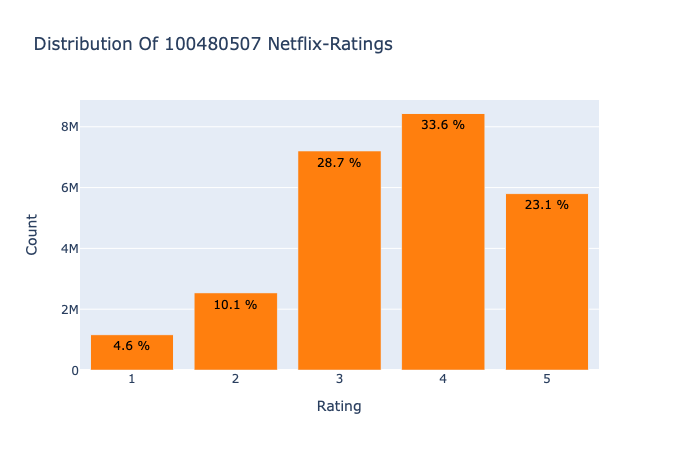

Average of rating: 3.60
Skewed to the left, skp: -1.09


In [30]:
# get data
data = smp['Rating'].value_counts().sort_index(ascending=False)

# create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / smp.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#ff7f0e'))
# create layout
layout = dict(title = f'Distribution Of {ts.shape[0]} Netflix-Ratings',
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# average ratings
avgRating = ts['Rating'].mean()
print(f'Average of rating: {avgRating:.2f}')

# sample Pearson coefficient skp
skp = (3*(ts['Rating'].mean() - 4))/ts['Rating'].std()
print(f'Skewed to the left, skp: {skp:.2f}')

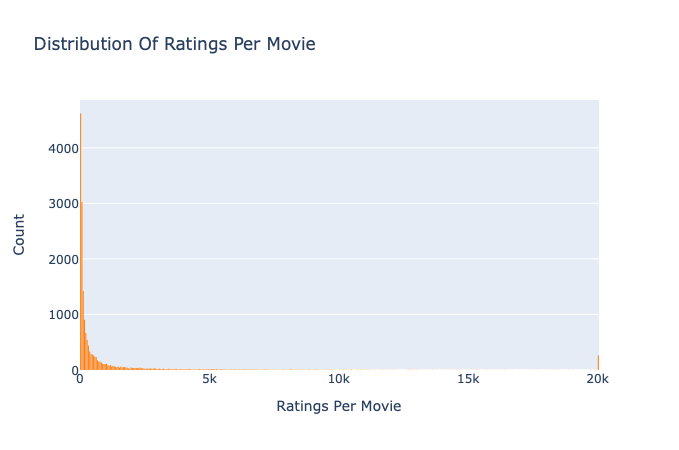

In [31]:
# get data
data = smp.groupby('MovieID')['Rating'].count().clip(upper = 20000)

# create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  size = 50), #10
                     marker = dict(color = '#ff7f0e'))
# create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

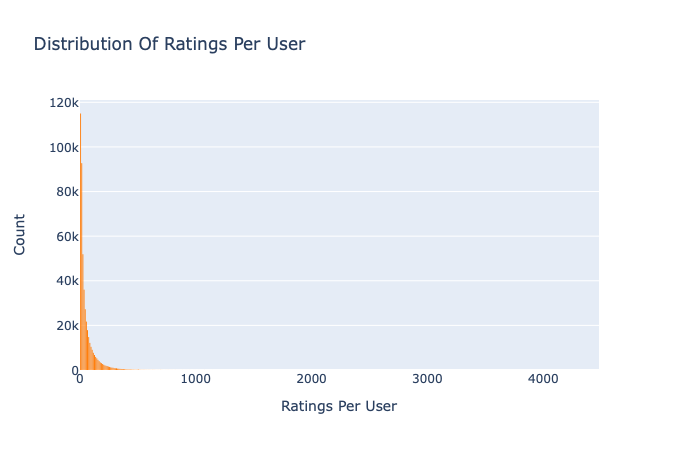

In [32]:
# get data
data = smp.groupby('CustomerID')['Rating'].count()

# create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  size = 10), # 4
                     marker = dict(color = '#ff7f0e'))
# create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [33]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (smp['MovieID'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 10
filter_users = (smp['CustomerID'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
smp_filterd = smp[(smp['MovieID'].isin(filter_movies)) & (smp['CustomerID'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings

print(f'Shape User-Ratings unfiltered:\t{smp.shape}')
print(f'Shape User-Ratings filtered:\t{smp_filterd.shape}')
print(f'Filter rate:\t{100*(1-smp_filterd.shape[0]/smp.shape[0]):.4f} %')

pkl.dump(smp_filterd, open('./pkl/smp_filterd.pkl', 'wb'))
smp_filterd

Shape User-Ratings unfiltered:	(25120127, 4)
Shape User-Ratings filtered:	(21771640, 4)
Filter rate:	13.3299 %


CustomerID  Rating        Date  MovieID
0            1003874       4  2003-09-05     9240
1            2273619       4  2005-11-08    15394
2             383024       2  2005-02-14     2122
5            2212438       4  2005-11-01     2379
6            2555054       3  2004-08-20     1001
...              ...     ...         ...      ...
25120122     2084556       3  2005-03-28     8295
25120123     2627800       3  2003-08-11     1428
25120124      585685       4  2005-07-17    15440
25120125     1145003       4  2002-08-02    17004
25120126      896738       4  2005-10-31    14868

[21771640 rows x 4 columns]

In [34]:
filter_customers = pd.unique(smp_filterd.CustomerID)
filter_movies = pd.unique(smp_filterd.MovieID)
smp_customers = pd.unique(smp.CustomerID)
smp_movies = pd.unique(smp.MovieID)

print(f'customer before sample: {smp_customers.size}, after sample: {filter_customers.size}, sample rate: {100*filter_customers.size/smp_customers.size:.2f}%') # 0.1
print(f'customer before sample: {smp_movies.size}, after sample: {filter_movies.size}, sample rate: {100*filter_movies.size/smp_movies.size:.2f}%')

customer before sample: 474673, after sample: 347522, sample rate: 73.21%
customer before sample: 17769, after sample: 3572, sample rate: 20.10%


In [35]:
# Shuffle DataFrame
smp_filterd = smp_filterd.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

# Split train- & testset
smp_train, smp_test = train_test_split(smp_filterd, test_size=0.2)

pkl.dump(smp_train, open('./pkl/smp_train.pkl', 'wb'))
pkl.dump(smp_test, open('./pkl/smp_test.pkl', 'wb'))